# Overview



# Load dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

words=open('/kaggle/input/character-lm-without-framework/names.txt', 'r').read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Build dataset

In [2]:
import random

def build_dataset(words):
    block_size=3 # context length: how many characters do we take to predict the next one?
    X,Y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y


random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr=build_dataset(words[:n1])
Xdev, Ydev=build_dataset(words[n1:n2])
Xte, Yte=build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Define the scale up network

Even if we scale up the dimension of our network's hidden layer. The dimension of the input layer is still the bottlebeck. So, we will scale up the dimension for both neural netwok input and hidden layers.

In [3]:
# definition of neural network
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((27,10), generator=g)
W1=torch.randn((30, 200), generator=g)
b1=torch.randn(200, generator=g)
W2=torch.randn((200, 27), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

# define a range of learning rate
lre=torch.linspace(-3, 0, 1000)
lrs=10**lre

lri=[]
lossi=[]
stepi=[]

11897


In [4]:
# training process
for i in range(10000):
    
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb=C[Xtr[ix]]
    h=torch.tanh(emb.view(-1, 30)@ W1+b1)
    logits=h @ W2+b2
    loss=F.cross_entropy(logits, Ytr[ix])
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i < 5000 else 0.01 # decay the loss
    for p in parameters:
        p.data+=-lr*p.grad

    # track stats
#     lri.append(lre[i]) # we track the exponent
    stepi.append(i)
    lossi.append(loss.log10().item()) # we use log10() squashes the hockey stick appearance looks nicer

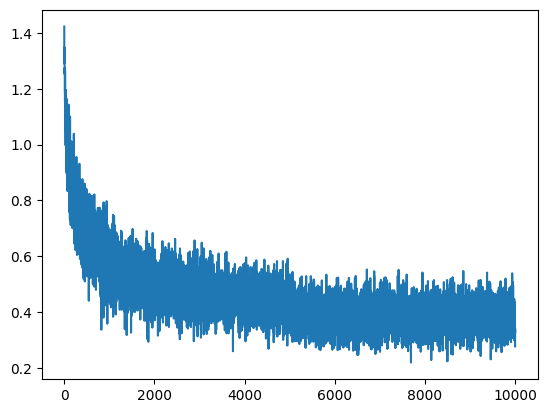

In [5]:
plt.plot(stepi, lossi)

In [6]:
emb=C[Xdev]
h=torch.tanh(emb.view(-1, 30)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits, Ydev)
loss

tensor(2.4074, grad_fn=<NllLossBackward0>)

In [7]:
emb=C[Xtr]
h=torch.tanh(emb.view(-1, 30)@W1+b1)
logits=h@W2+b2
loss=F.cross_entropy(logits, Ytr)
loss

tensor(2.4050, grad_fn=<NllLossBackward0>)

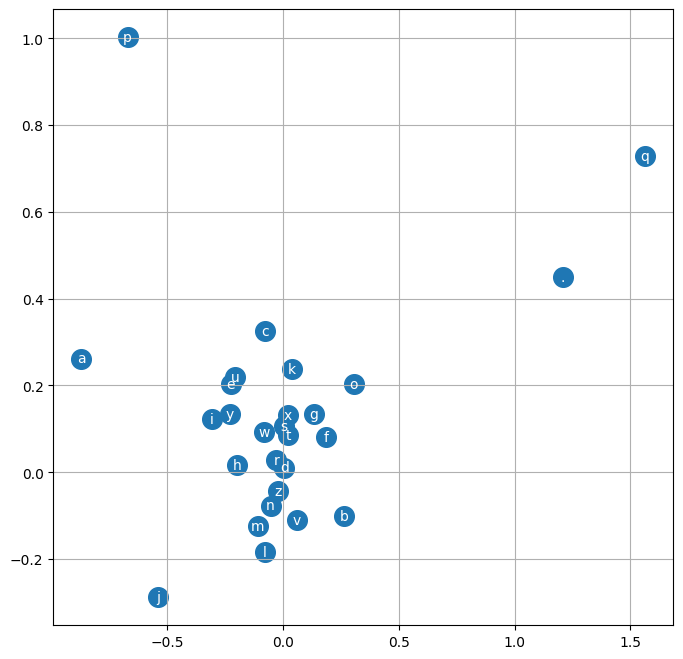

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')

# Sample from the model

In [9]:
g=torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out=[]
    context =[0]*3 # initialize with all, 3 is block size
    while True:
        emb=C[torch.tensor([context])] # (1,block_size,d)
        h=torch.tanh(emb.view(1,-1) @W1+b1)
        logits=h@W2+b2
        probs=F.softmax(logits, dim=1)
        ix=torch.multinomial(probs, num_samples=1, generator=g).item() # sample from probabilities by using multinomimal
        context=context[1:]+[ix] # shift the context window to append the index and record it
        out.append(ix)
        if ix ==0:
            break
            
    print(''.join(itos[i] for i in out)) # decode the integers to strings

mria.
kayan.
seel.
ndun.
ala.
emmasiend.
len.
adered.
elin.
shi.
jelle.
eliean.
aar.
katelvina.
amn.
sadbergahiries.
kinleenlyn.
xoberce.
ubrin.
dar.


# Acknowledgements

* https://youtu.be/TCH_1BHY58I?si=z3g6RDwnaAusL357
* https://www.kaggle.com/code/aisuko/multilayer-perceptron-optimise-overfitting/notebook